# **BBM409 ASSIGNMENT 2**

        Eylül TUNCEL - 21727801
        Emre KÖSEN   - 21727498

## **Diabetes Risk Prediction**


In this assignment, we implemented a decision tree model to predict whether a patient is a potential diabetic or not. We used ID3 Algorithm on discrete attributes on the dataset and we applied the discretization process on continuous attribute (”Age” attribute).
In the second part of this assignment we prevent overfit in our decision tree by pruning the twigs of our tree.

### Classification Dataset: Diabetes Risk Prediction Dataset

• Attribute and Class Information:
1. Age (Continuous Attribute)
2. Gender (Male, Female)
3. Polyuria (Yes, No)
4. Polydipsia (Yes, No)
5. Sudden Weight Loss (Yes, No)
6. Weakness (Yes, No)
7. Polyphagia (Yes, No)
8. Genital Thrush (Yes, No)
9. Visual Blurring (Yes, No)
10. Itching (Yes, No)
11. Irritability (Yes, No)
12. Delayed Healing (Yes, No)
13. Partial Paresis (Yes, No)
14. Muscle Stiffness (Yes, No)
15. Alopecia (Yes, No)
16. Obesity (Yes, No)
17. Class (Output Prediction Class Information, ”Positive” or ”Negative”)

In [1]:
import math
import numpy as np
import pandas as pd

In [2]:
# Node class for creating decision tree
# every node has name -> attribute names
#                values -> attribute values [ val1 , val2 , .. ]
#                children -> selected child node for sequentially ordered values [ child of val1, child of val2 , ..]
#                class_distribution -> positive and negative class distribution of node as [ positive# , negative# ]
#                information_gain -> calculated information gain of the node
#
#        Attribute (Node)       --> name
#           /        \
#         yes         no        --> values
#         /            \
#       Attr           Attr     --> children
class Node(object):
    def __init__(self, name, values):
        self.name = name
        self.values = values
        self.information_gain = -1
        self.class_distribution = []
        self.children = []

    def add_child(self, obj):
        self.children.append(obj)

    def __str__(self, level=0):
        ret = "\t   |" * level + "+---- " + repr(self.name) + "\n"
        for child in self.children:
            ret += child.__str__(level + 1)
        return ret

    def __repr__(self):
        return '<tree node representation>'

### **Discretization** 

Data discretization is defined as a process of converting continuous data attribute values into a finite set of intervals and associating with each interval some specific data value. In our case the "Age" attribute has continuous data which varies betwee 16 to 90. We did discretization and creating five intervals between your range of minimumand maximum values. 
   * group1 --> between 16 and 30
   * group2 --> between 30 and 45
   * group3 --> between 45 and 60
   * group4 --> between 60 and 75
   * group5 --> between 75 and 90

In [3]:
# discretization function for "Age" attribute which is continuous attribute
def discretization(x):
    col = []
    # for each row of 'Age' column append all values to column array
    for i in range(x.shape[0]):
        col.append(x[i, 0])
    # sort the column array so the first index contains min value, last index contains max value for that column
    col.sort()
    min_of_col = col[0]
    max_of_col = col[x.shape[0] - 1]

    # find the interval when we divide the range with 5
    interval = (max_of_col - min_of_col + 1) / 5

    # for this data set ou age values vary between 16-90
    # when we divide this data to 5 groups
    #                           group 1 --> between 16 and 30
    #                           group 2 --> between 30 and 45
    #                           group 3 --> between 45 and 60
    #                           group 4 --> between 60 and 75
    #                           group 5 --> between 75 and 90
    for j in range(x.shape[0]):
        # 16->30
        if min_of_col <= x[j, 0] < min_of_col + interval:
            x[j, 0] = "group1"

        # 30->45
        elif min_of_col + interval <= x[j, 0] < min_of_col + (2 * interval):
            x[j, 0] = "group2"

        # 45->60
        elif min_of_col + (2 * interval) <= x[j, 0] < min_of_col + (3 * interval):
            x[j, 0] = "group3"

        # 60->75
        elif min_of_col + (3 * interval) <= x[j, 0] < min_of_col + (4 * interval):
            x[j, 0] = "group4"

        # 75->90
        elif min_of_col + (4 * interval) <= x[j, 0] < min_of_col + (5 * interval):
            x[j, 0] = "group5"
    return x

In [4]:
def k_fold(x):
    # start and end points of each fold
    size = int(x.shape[0] / 5)
    arr = [0, size, 2 * size, 3 * size, 4 * size, 5 * size]
    # for each fold, we create our test and train set and then call KNN classification function
    for i in range(5):
        # 1/5 part of the data set as test data
        x_test = x[arr[i]:arr[i + 1]]

        # rest of the data set as train data
        a = x[0:arr[i]]
        b = x[arr[i + 1]:]
        x_train = np.concatenate((a, b), axis=0)

        attributes = {"age": 0, "gender": 1, "polyuria": 2, "polydipsia": 3, "sudden weight loss": 4,
                      "weakness": 5, "polyphagia": 6, "penital thrush": 7, "visual blurring": 8,
                      "itching": 9, "irritability": 10, "delayed healing": 11, "partial paresis": 12,
                      "muscle stiffness": 13, "alopecia": 14, "obesity": 15}

        print()
        print("--------------------------FOLD", i + 1, "--------------------------------------------")

        root = ID3(x_train, attributes)
        print(root)

        accuracy, precision, recall, f1_score = classification_performance(root, x_test)
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 Score: ", f1_score)

    return

### **Decision Tree and ID3 Algorithm**

A decision tree is used to build classification and regression models in the form of a tree structure. A decision tree is a tree where each :
* **Node** is a feature(attribute)
* **Branch** is a decision(rule)
* **Leaf** is an outcome(categorical or continuous)

#### **ID3 Algorithm**
It is a classification algorithm that follows a greedy approach by selecting a best attribute that yields maximum Information Gain.
1. A ← the “best” decision attribute for next node
2. Assign A as decision attribute for node
3. For each value of A create new descendant node
4. Sort training examples to leaf node according to the attribute value of the branch
5. If all training examples are perfectly classified (same value of target attribute) STOP, else iterate over new leaf nodes.

In [5]:
def ID3(data, rem_features):

    # find majority of the classes and make a guess
    positive, negative = find_most_frequent(data)
    if positive > negative:
        guess = "Positive"
    else:
        guess = "Negative"

    # base case: if there arent any positive instances then leaf must be labeled negative
    if positive == 0:
        return Node("LEAF-Negative", ["Negative"])
    # base case: if there arent any negative instances then leaf must be labeled positive
    elif negative == 0:
        return Node("LEAF-Positive", ["Positive"])
    # base case: if there arent any attributes left to classify, then we must choose majority of the labels as leaf node
    elif len(rem_features) == 0:
        return Node("LEAF-" + guess, [guess])

    else:
        # finding distribution of the classes for each of the attributes
        class_distribution = find_class_distribution(data, rem_features)

        # between all of the remaining attributes, calculate information gain of each of them
        info_gain = calculate_info_gain(class_distribution, rem_features)

        # select the best node (highest information gain) and make it the next node in the tree
        node_name = select_next_node(info_gain)

        if node_name == "":
            return Node("LEAF-" + guess, [guess])

        # get all the values of that specific attribute like [yes, no], [male, female]
        node_values = []
        for x in class_distribution.get(node_name):
            if x != "total":
                node_values.append(x)

        features = rem_features.copy()
        # pop out selected attribute from remaining features
        rem_features.pop(node_name)
        node_children = []

        for i in node_values:
            # take subset of the selected value in the data
            subset = np.ndarray([0, 17])
            for row in range(len(data)):
                val = data[row, features.get(node_name)]
                if val.lower() == i:
                    subset = np.vstack([subset, data[row, :]])

            # to continue making decision tree, call ID3 function recursively
            node_children.append(ID3(subset, rem_features.copy()))

        # create a node in the tree with selected attributes
        node = Node(node_name, node_values)
        node.children = node_children
        node.information_gain = info_gain.get(node_name)
        node.class_distribution = class_distribution.get(node_name).get("total")
        return node

In [6]:
# finding most frequent function is necessary for the base case of the ID3 algorithm
# when there is no more attribute left in the tree, we choose most frequent value for the leaf
def find_most_frequent(data):
    positive_count = 0
    negative_count = 0
    for i in range(len(data)):
        if data[i, 16] == "Positive":
            positive_count += 1
        else:
            negative_count += 1
    return positive_count, negative_count

In [7]:
# this function returns a class distribution dictionary which is nested dictionary
# inside that nested dictionary there is attribute names as value and distribution of attributes as a key, for example;
# class_distribution = { 'Gender': {'Male': [18, 36], 'Female': [48, 16]},
#                        'Polyuria': {'Yes': '[22, 58], 'No': [18, 20]}     }
# the first index in the list shows positive classified sample count and second index shows negatively classified ones
def find_class_distribution(x, attributes):
    class_distribution = {}

    for attr in attributes:
        col = attributes.get(attr)

        # first column belongs to "Age" attribute which has 5 discrete values
        if col == 0:
            age_dict = {"group1": [0, 0],
                        "group2": [0, 0],
                        "group3": [0, 0],
                        "group4": [0, 0],
                        "group5": [0, 0],
                        "total": [0, 0]
                        }
            for row in range(len(x)):
                if x[row, col] == "group1":
                    if x[row, 16] == "Positive":
                        age_dict["group1"][0] += 1
                    else:
                        age_dict["group1"][1] += 1

                elif x[row, col] == "group2":
                    if x[row, 16] == "Positive":
                        age_dict["group2"][0] += 1
                    else:
                        age_dict["group2"][1] += 1

                elif x[row, col] == "group3":
                    if x[row, 16] == "Positive":
                        age_dict["group3"][0] += 1
                    else:
                        age_dict["group3"][1] += 1

                elif x[row, col] == "group4":
                    if x[row, 16] == "Positive":
                        age_dict["group4"][0] += 1
                    else:
                        age_dict["group4"][1] += 1

                elif x[row, col] == "group5":
                    if x[row, 16] == "Positive":
                        age_dict["group5"][0] += 1
                    else:
                        age_dict["group5"][1] += 1

            # for total value of age attribute distribution
            age_dict["total"][0] += age_dict["group1"][0]
            age_dict["total"][0] += age_dict["group2"][0]
            age_dict["total"][0] += age_dict["group3"][0]
            age_dict["total"][0] += age_dict["group4"][0]
            age_dict["total"][0] += age_dict["group5"][0]

            age_dict["total"][1] += age_dict["group1"][1]
            age_dict["total"][1] += age_dict["group2"][1]
            age_dict["total"][1] += age_dict["group3"][1]
            age_dict["total"][1] += age_dict["group4"][1]
            age_dict["total"][1] += age_dict["group5"][1]

            # add age attribute  to the class distribution dictionary
            class_distribution["age"] = age_dict

        # second column is "Gender" column which has 2 values (female, male)
        elif col == 1:
            gender_dict = {"male": [0, 0],
                           "female": [0, 0],
                           "total": [0, 0]}

            # for each row of that specific column
            for row in range(len(x)):
                if x[row, col] == "Male":
                    if x[row, 16] == "Positive":
                        gender_dict["male"][0] += 1
                    else:
                        gender_dict["male"][1] += 1

                elif x[row, col] == "Female":
                    if x[row, 16] == "Positive":
                        gender_dict["female"][0] += 1
                    else:
                        gender_dict["female"][1] += 1

            gender_dict["total"][0] += gender_dict["male"][0]
            gender_dict["total"][0] += gender_dict["female"][0]

            gender_dict["total"][1] += gender_dict["male"][1]
            gender_dict["total"][1] += gender_dict["female"][1]

            # add gender attribute  to the class distribution dictionary
            class_distribution["gender"] = gender_dict

        # all the other attributes has yes/no values
        else:
            attr_dict = {"yes": [0, 0],
                         "no": [0, 0],
                         "total": [0, 0]}

            # for each row of that specific column
            for row in range(len(x)):
                if x[row, col] == "Yes":
                    if x[row, 16] == "Positive":
                        attr_dict["yes"][0] += 1
                    else:
                        attr_dict["yes"][1] += 1

                elif x[row, col] == "No":
                    if x[row, 16] == "Positive":
                        attr_dict["no"][0] += 1
                    else:
                        attr_dict["no"][1] += 1

            attr_dict["total"][0] += attr_dict["yes"][0]
            attr_dict["total"][0] += attr_dict["no"][0]

            attr_dict["total"][1] += attr_dict["yes"][1]
            attr_dict["total"][1] += attr_dict["no"][1]

            # add that column to the class distribution dictionary
            class_distribution[attr] = attr_dict

    # print_nested_dict(class_distribution)
    return class_distribution

### **Information Gain**

Information gain measures how well a given attribute separates the training examples according to their target classification.

* **S**          = Collection of examples
* **A**          = Attribute
* **Values(A)**  = Possible values of attribute A
* **Sv**         = The subset of S for which attribute A has value v

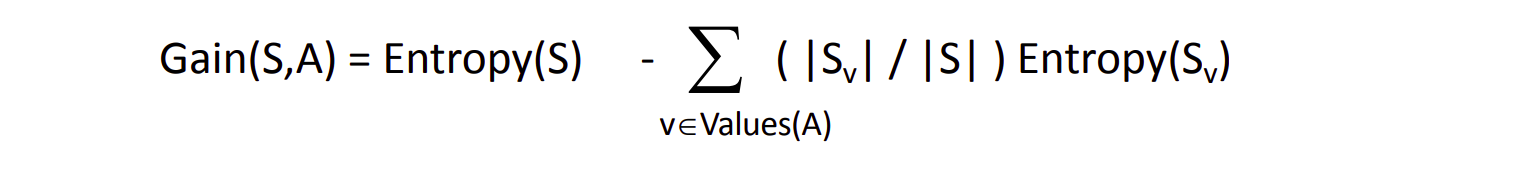


ID3 uses this information gain measure to select among the remaining attributes at each step while growing the tree.In order to define information gain precisely, we use a measure commonly used in information theory, called entropy. A larger information gain suggests a lower entropy groups of samples, and hence less surprise.

In [8]:
# calculating information gain for all remaining attributes given in the parameter
def calculate_info_gain(dist, attributes):
    # dictionary for attributes and respective information gains of them
    info_gain = {"age": 0, "gender": 0, "polyuria": 0, "polydipsia": 0, "sudden weight loss": 0,
                 "weakness": 0, "polyphagia": 0, "penital thrush": 0, "visual blurring": 0,
                 "itching": 0, "irritability": 0, "delayed healing": 0, "partial paresis": 0,
                 "muscle stiffness": 0, "alopecia": 0, "obesity": 0}
    for attr in attributes:
        gain = calculate_entropy(dist.get(attr).get("total"))
        for i in dist.get(attr):
            if i != "total":
                sv = dist.get(attr).get(i)[0] + dist.get(attr).get(i)[1]
                s = dist.get(attr).get("total")[0] + dist.get(attr).get("total")[1]
                ent_sv = calculate_entropy(dist.get(attr).get(i))
                gain -= abs(sv / s) * ent_sv
        info_gain[attr] = gain
    return info_gain

### **Entrophy**

Entropy characterizes the (im)purity of an arbitrary collection of examples.Entrophy is a measure of the randomness in the information being processed. The higher the entropy, the harder it is to draw any conclusions from that information. Entrophy value ranges from 0 to 1. Below you can see the formula and respective graph of entrophy.
* S is a sample of training examples
* p+ is the proportion of positive examples
* p- is the proportion of negative examples

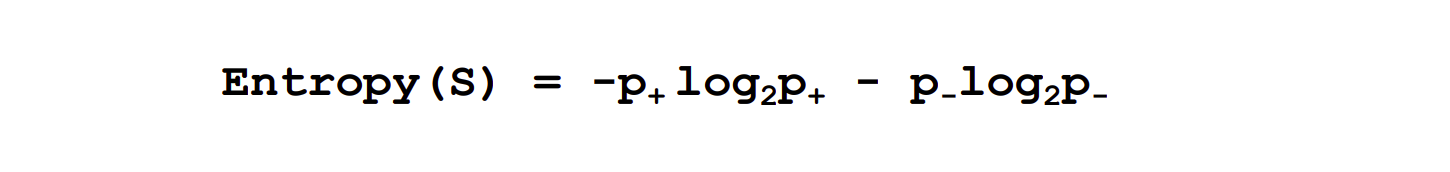

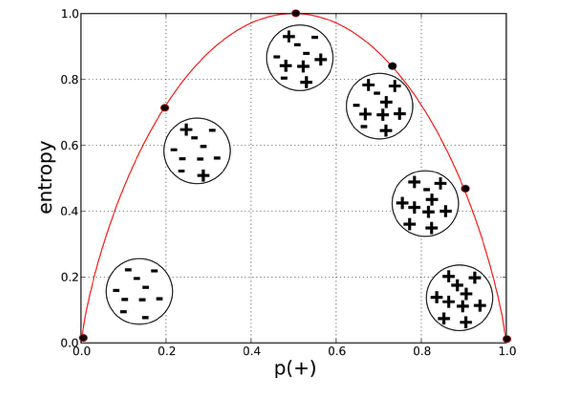

In [9]:
# this function calculates entropy of the given positive and negative values
# parameter "dist" is distribution of positive and negative values for an attribute
def calculate_entropy(dist):
    total = dist[0] + dist[1]
    if total == 0:
        return 1
    pos_prop = dist[0] / total
    neg_prop = dist[1] / total
    log = lambda prop: math.log(prop, 2) if prop != 0 else 0
    entropy = -(pos_prop * log(pos_prop)) - (neg_prop * log(neg_prop))
    return entropy

In [10]:
# next node of the tree is selected based on this function,
# we calculate information gain for all remaining attributes, and select best of it for the next node
def select_next_node(info_gain):
    max_info_gain = 0
    best_attr = ""
    for x in info_gain:
        if info_gain.get(x) > max_info_gain:
            best_attr = x
            max_info_gain = info_gain.get(x)
    return best_attr

### **Performance Metrics** 

#### **Confusion Matrix**
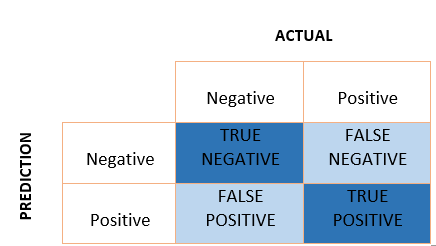


* True Positive (TP) — model correctly predicts the positive class (prediction and actual both are positive).
* True Negative (TN) — model correctly predicts the negative class (prediction and actual both are negative).
* False Positive (FP) — model gives the wrong prediction of the negative class (predicted-positive, actual-negative). 
* False Negative (FN) — model wrongly predicts the positive class (predicted-negative, actual-positive).


#### **Accuracy**

Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. We may think, when the accuracy is high, our model is the best, but it is only true when we have symmetric dataset. Accuracy is great measure for performance but it is not always the best way, therefore we have to look other parameters to evaluate the performance of our model.
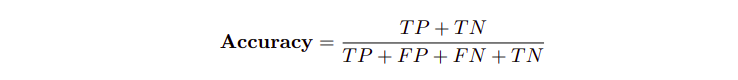

#### **Precision**
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.Precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made. The precision score is a useful measure of the success of prediction when the classes are very imbalanced.
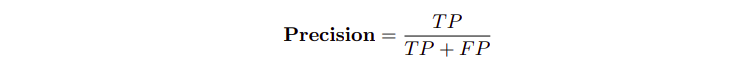

#### **Recall**
Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made. 
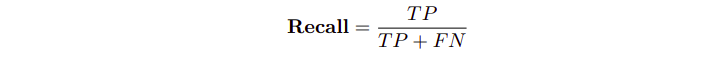

#### **F1 Score**
It is the harmonic mean of precision and recall. It takes both false positive and false negatives into account. Therefore, it performs well on an imbalanced dataset. It’s often used as a single value that provides high-level information about the model’s output quality. 
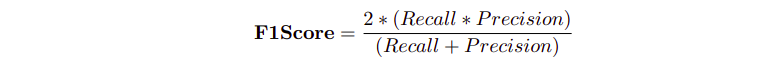

In [11]:
# for testing performance we use accuracy, recall, precision and f1 score metrics
# those metrics are calculated in the function below
def classification_performance(root, x_test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for sample in x_test:
        prediction = decision_tree_test(root, sample)
        if prediction == sample[16] and prediction == "Positive":
            tp += 1
        elif prediction == sample[16] and prediction == "Negative":
            tn += 1
        if prediction != sample[16] and prediction == "Positive":
            fp += 1
        elif prediction != sample[16] and prediction == "Negative":
            fn += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * recall * precision) / (recall + precision)
    return accuracy, precision, recall, f1_score

In [12]:
def decision_tree_test(node, test):
    # attributes and their respective indices in the data is given with dictionary
    attributes = {"age": 0, "gender": 1, "polyuria": 2, "polydipsia": 3, "sudden weight loss": 4,
                  "weakness": 5, "polyphagia": 6, "penital thrush": 7, "visual blurring": 8,
                  "itching": 9, "irritability": 10, "delayed healing": 11, "partial paresis": 12,
                  "muscle stiffness": 13, "alopecia": 14, "obesity": 15}

    # if it is leaf node then return the class of if (Positive/Negative)
    if node.name == "LEAF-Positive" or node.name == "LEAF-Negative":
        return node.values[0]
    # if it ii one of the internal nodes, then go one more level down in decision tree
    else:
        for val in node.values:
            if test[attributes.get(node.name)].lower() == val:
                index = node.values.index(val)
                child_node = node.children[index]
                return decision_tree_test(child_node, test)


In [13]:
def k_fold_and_prune(x):
    # start and end points of each fold
    size = int(x.shape[0] / 5)
    arr = [0, size, 2 * size, 3 * size, 4 * size, 5 * size]
    # for each fold, we create our test and train set and then call KNN classification function
    for i in range(5):
        # 1/5 part of the data set as validation set
        x_validation = x[arr[i]:arr[i + 1]]

        if i != 4:
            # 1/5 part of the data set as test set
            x_test = x[arr[i + 1]:arr[i + 2]]
            # rest of the data set as train data
            a = x[0:arr[i]]
            b = x[arr[i + 2]:]
            x_train = np.concatenate((a, b), axis=0)
        else:
            x_test = x[0:arr[1]]
            x_train = x[arr[1]:arr[4]]

        attributes = {"age": 0, "gender": 1, "polyuria": 2, "polydipsia": 3, "sudden weight loss": 4,
                      "weakness": 5, "polyphagia": 6, "penital thrush": 7, "visual blurring": 8,
                      "itching": 9, "irritability": 10, "delayed healing": 11, "partial paresis": 12,
                      "muscle stiffness": 13, "alopecia": 14, "obesity": 15}

        print()
        print("--------------------------FOLD", i + 1, "--------------------------------------------")

        root = ID3(x_train, attributes)
        # print(root)

        accuracy_test, precision_test, recall_test, f1_score_test = classification_performance(root, x_test)
        print("Accuracy Before Pruning: ", accuracy_test)
        print("Precision Before Pruning: ", precision_test)
        print("Recall Before Pruning: ", recall_test)
        print("F1 Score Before Pruning: ", f1_score_test)
        print()

        root = prune_tree(root, x_validation)
        print(root)

        accuracy, precision, recall, f1_score = classification_performance(root, x_test)
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 Score: ", f1_score)
    return


### **Decision Tree Pruning**
Pruning is a technique that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.
Eventually each leaf will reperesent a very specific set of attribute combinations that are seen in the training data, and the tree will consequently not be able to classify attribute value combinations that are not seen in the training data.

In order to prevent this from happening, we must prune the decision tree.By pruning we mean that the lower ends (the leaves) of the tree are “snipped” until the tree is much smaller. The figure below shows an example of a full tree, and the same tree after it has been pruned to have only 4 leaves.

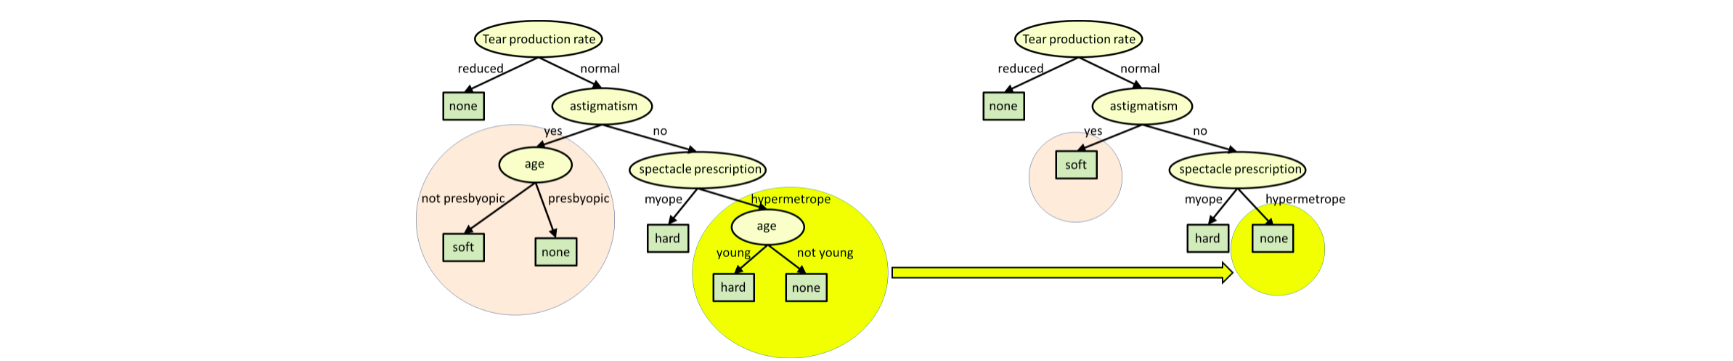

In [14]:
# prune tree function identifies the twigs which are not necessary for prediction,  based on the information gain
def prune_tree(root, x_validation):
    current_accuracy = classification_performance(root, x_validation)[0]
    last_accuracy = classification_performance(root, x_validation)[0]

    # finding least informative twig based on the information gain values
    twig = find_least_informative_twig(root)

    # while accuracy is not changing or increasing, we keep pruning the tree
    while current_accuracy >= last_accuracy:
        # save those information for reverting the last changes if necessary
        name = twig.name
        values = twig.values
        children = twig.children
        info_gain = twig.information_gain

        # based on majority of class(positive/negative) we replace twig with a leaf
        if twig.class_distribution[0] >= twig.class_distribution[1]:
            twig.name = "LEAF-Positive"
            twig.values = ["Positive"]
            twig.children = []
            twig.information_gain = -1
        elif twig.class_distribution[1] > twig.class_distribution[0]:
            twig.name = "LEAF-Negative"
            twig.values = ["Negative"]
            twig.children = []
            twig.information_gain = -1

        last_accuracy = current_accuracy
        current_accuracy = classification_performance(root, x_validation)[0]

        # if current accuracy decreases then we must revert the changes we made in the last twig
        if current_accuracy < last_accuracy:
            twig.name = name
            twig.values = values
            twig.children = children
            twig.information_gain = info_gain
            current_accuracy = classification_performance(root, x_validation)[0]
            break

        twig = find_least_informative_twig(root)
    return root

In [15]:
# finding least informative twig requires to look all of the twigs and their respective information gain values
# for traversing the tree we use preorder traversal method and find all twigs
def find_least_informative_twig(root):
    all_twigs = []
    # all twigs are collected at the end of his function
    preorder_traversal_util(root, all_twigs)
    info_gain = 1
    least_informative_twig = None
    # between all twigs search for the least informative one
    for twig in all_twigs:
        if info_gain >= twig.information_gain:
            info_gain = twig.information_gain
            least_informative_twig = twig
    return least_informative_twig


In [16]:
# in preorder traversal of tree we search all nodes to find twigs in the tree
# twigs are the nodes which are their all children were leaves
def preorder_traversal_util(root, all_twigs):
    # when found a leaf, return ( base case)
    if root.values[0] == "Positive" or root.values[0] == "Negative":
        return

    # if the node is not leaf then look if its all children are leaves ( twig node )
    leaf_count = 0
    for item in root.children:
        if item.values[0] == "Positive" or item.values[0] == "Negative":
            leaf_count += 1
    if leaf_count == len(root.children):
        all_twigs.append(root)

    # recursively call the function to continue searching
    for child in root.children:
        preorder_traversal_util(child, all_twigs)
    return

In [17]:
# reading data's in the csv file to the numpy array
df = pd.read_csv('./diabetes_data_upload.csv')
x = np.array(df.iloc[:, :])

# discretization on age attribute
x = discretization(x)

# shuffle the data
np.random.seed(101)
np.random.shuffle(x)

In [18]:
k_fold(x.copy())


--------------------------FOLD 1 --------------------------------------------
+---- 'polydipsia'
	   |+---- 'polyuria'
	   |	   |+---- 'LEAF-Positive'
	   |	   |+---- 'irritability'
	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |+---- 'muscle stiffness'
	   |	   |	   |	   |+---- 'gender'
	   |	   |	   |	   |	   |+---- 'visual blurring'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |+---- 'polyuria'
	   |	   |+---- 'itching'
	   |	   |	   |+---- 'penital thrush'
	   |	   |	   |	   |+---- 'obesity'
	   |	   |	   |	   |	   |+---- 'age'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |+---- 'LEAF-Positiv

In [19]:
k_fold_and_prune(x.copy())


--------------------------FOLD 1 --------------------------------------------
Accuracy Before Pruning:  0.9230769230769231
Precision Before Pruning:  0.9666666666666667
Recall Before Pruning:  0.90625
F1 Score Before Pruning:  0.9354838709677419

+---- 'polydipsia'
	   |+---- 'polyuria'
	   |	   |+---- 'LEAF-Positive'
	   |	   |+---- 'irritability'
	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |+---- 'visual blurring'
	   |	   |	   |	   |+---- 'alopecia'
	   |	   |	   |	   |	   |+---- 'delayed healing'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |+---- 'LEAF-Positive'
	   |+---- 'polyuria'
	   |	   |+---- 'itching'
	   |	   |	   |+---- 'penital thrush'
	   |	   |	   |	   |+---- 'obesity'
	   |	   |	   |	   |	   |+---- 'age'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |+---- 'LEAF-Negative'
	   |	   |	   |	   |	   |	   |

# **Error Analysis for Classification**

## **Part 1: Diabetes Risk Prediction**
Below you can see all of the performance metrics in one table.

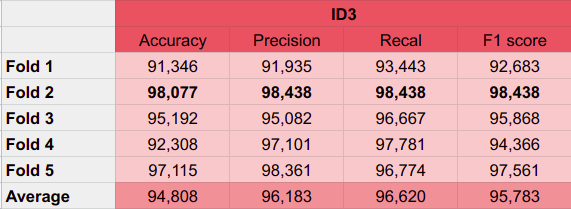

best rule ...

comparison between performance metrics

### **1.Possible Reasons to Misclassified Samples**

Find a few misclassified samples and comment on why you think they were hardto classify.








• 

### **2.Performance** 
Compare performance of different ID3 model variation choices with respect to 5- fold cross-validation. Wherever relevant, feel free to discuss computation time in addition to classification rate.

## **Part 2: Pruning Decision Tree**
Below you can see all of the performance metrics in one table.

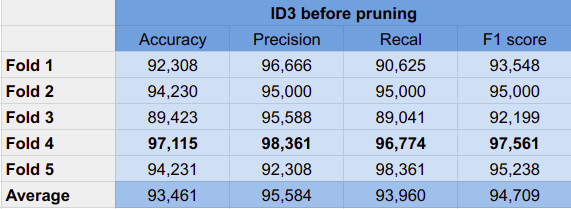 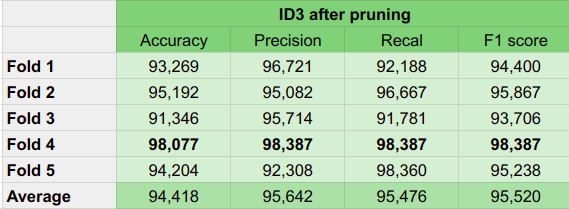


### **2.Performance** 
Compare performance of different ID3 model variation choices with respect to 5- fold cross-validation. Wherever relevant, feel free to discuss computation time in addition to classification rate.